# multiclass classification example - SF crime dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import numpy as np
import pandas as pd
import databricks.koalas as ks
from pandas.testing import assert_frame_equal
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from hyperopt import hp
from hyperopt import tpe

In [4]:
from pyspark import SparkConf, SparkContext
conf = SparkConf()
conf.set('spark.executor.memory', '2g')
SparkContext(conf=conf)
ks.set_option('compute.default_index_type', 'distributed-sequence')

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/30 11:36:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
21/11/30 11:36:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
21/11/30 11:36:06 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
21/11/30 11:36:06 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
21/11/30 11:36:06 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [32]:
from gators.util import util
# data cleaning
from gators.data_cleaning import (
    ConvertColumnDatatype,
    DropHighNaNRatio,
    DropLowCardinality,
    DropHighCardinality,
    DropDatatypeColumns,
    DropColumns,
    KeepColumns
)
# imputers
from gators.imputers import (
    NumericsImputer, 
    ObjectImputer,
)
# encoders
from gators.encoders import (
    WOEEncoder, 
    MultiClassEncoder, 
    TargetEncoder,
    OrdinalEncoder,
)
# binning
from gators.binning import (
    BinRareCategories,
    TreeBinning,
)
# feature generation
from gators.feature_generation import (
    ClusterStatistics,
    PolynomialObjectFeatures,
    PolynomialFeatures
)
from gators.feature_generation_str import (
    StringContains,
    StringLength,
    Extract,
    SplitExtract,
)
from gators.feature_generation_dt import (
    CyclicHourOfDay,
    CyclicDayOfMonth,
    CyclicDayOfWeek,
    CyclicMonthOfYear,
    OrdinalDayOfMonth,
    OrdinalMonthOfYear,
    OrdinalDayOfWeek,
    OrdinalHourOfDay,
)
# feature selection
from gators.feature_selection import (
    MultiClassInformationValue,
    SelectFromModel,
)
# feature generation
from gators.feature_generation import PlaneRotation
# model building
from gators.model_building import (
    TrainTestSplit,
    HyperOpt,
    XGBBoosterBuilder,
    XGBTreeliteDumper,
    LGBMTreeliteDumper,
)
# pipeline
from gators.pipeline import Pipeline

## offline pipeline - feature selection

In [130]:
model = LGBMClassifier(random_state=0, n_jobs=-1)
k = 60

offline_steps = [
    ConvertColumnDatatype(columns=['Dates'], datatype='datetime64[ns]'),
    OrdinalHourOfDay(columns=['Dates']),
    OrdinalDayOfWeek(columns=['Dates']),
    OrdinalDayOfMonth(columns=['Dates']),
    CyclicHourOfDay(columns=['Dates']),
    CyclicDayOfWeek(columns=['Dates']),
    CyclicDayOfMonth(columns=['Dates']),
    StringContains(
        columns=['Address', 'Address', 'Address', 'Address'], 
        contains_vec=['/', 'AV', 'ST', 'Block'], 
        column_names=['IsIntersection', 'IsAvenue', 'IsStreet', 'IsBlock']),
    DropColumns(columns=['Dates', 'Address']),
    PlaneRotation(
        columns= [['X','Y']], 
        theta_vec= np.arange(5, 46, 5).tolist()),
    MultiClassEncoder(OrdinalEncoder()),
    MultiClassInformationValue(
        binning=TreeBinning(max_depth=2, inplace=True), 
        k=10),
]
offline_pipe = Pipeline(steps=offline_steps)


### pandas

In [131]:
data = pd.read_parquet('data/sf_crime.parquet')
data = data.reset_index(drop=True)
y = data['Category'].copy()
X = data.drop(['Category'], axis=1)

base_columns = list(X.columns)
classes = y.unique()
mapping = dict(zip(classes, range(len(classes))))
y = y.replace(mapping)

train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train, X_test, y_train, y_test = train_test_split.transform(X, y)

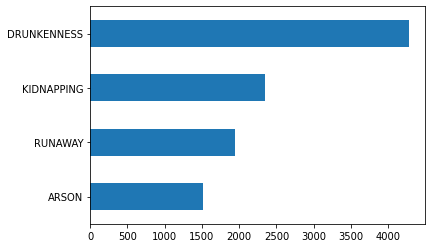

In [132]:
# target analysis
data['Category'].value_counts().iloc[::-1].plot(kind='barh');

In [137]:
print(X_train.shape)
_ = offline_pipe.fit(X_train, y_train)
features = list(X_train_prepro.columns)

(7056, 19)
111 (7056, 37)
binning.output_columns []
binning.output_columns []
columns []
333 (7056, 37)
000 (7056, 0)
222 Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[7056 rows x 0 columns]
Series([], dtype: object)
object_columns []
numerical_columns []
HERE []
Series([], dtype: int64)
Series([], dtype: int64)
000 (7056, 0)
222 Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,

In [134]:
offline_pipe.transform(X_train)

,Unnamed: 0,X,Y,Dates__hour_of_day,Dates__day_of_week,Dates__day_of_month,Dates__hour_of_day_cos,Dates__hour_of_day_sin,Dates__day_of_week_cos,Dates__day_of_week_sin
0,0.0,-122.412929,37.789687,19.0,2.0,13.0,0.460065,-0.887885,-0.5,0.866025
1,1.0,-122.424348,37.745046,12.0,2.0,13.0,-0.990686,-0.136167,-0.5,0.866025
2,2.0,-122.449675,37.709763,9.0,2.0,13.0,-0.775711,0.631088,-0.5,0.866025
3,3.0,-122.419667,37.774682,4.0,2.0,13.0,0.460065,0.887885,-0.5,0.866025
4,4.0,-122.403916,37.790539,22.0,1.0,12.0,0.962917,-0.269797,0.5,0.866025
...,...,...,...,...,...,...,...,...,...,...
7051,7051.0,-122.444995,37.777440,12.0,4.0,6.0,-0.990686,-0.136167,-0.5,-0.866025
7052,7052.0,-122.422614,37.792643,8.0,4.0,6.0,-0.576680,0.816970,-0.5,-0.866025
7053,7053.0,-122.422614,37.792643,8.0,4.0,6.0,-0.576680,0.816970,-0.5,-0.866025
7054,7054.0,-122.403405,37.775421,6.0,4.0,6.0,-0.068242,0.997669,-0.5,-0.866025


In [55]:
offline_pipe.get_feature_importances(60)[::-1].plot(
    kind='barh', 
    figsize=(14,9), 
    title='Feature Importance',
);

AttributeError: The last step of the pipeline should have
                 the attribute `feature_importances_`

### koalas

In [11]:
data = ks.read_parquet('data/sf_crime.parquet', index_col='Id')
y_ks = data['Category']
X_ks = data.drop(
    ['Resolution', 'Descript', 'DayOfWeek', 'Category'], axis=1)
X_ks.index.name = None
y_ks = y_ks.replace(mapping).astype(int)

train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train_ks, X_test_ks, y_train_ks, y_test_ks = \
    train_test_split.transform(X_ks, y_ks)

In [12]:
offline_pipe = Pipeline(steps=offline_steps)
X_train_prepro_ks = offline_pipe.fit_transform(X_train_ks, y_train_ks)
X_train_prepro_ks_np = offline_pipe.transform_numpy(X_train_ks.to_numpy())

21/09/30 11:18:41 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


#### check pandas and koalas results match - offline pipeline

In [13]:
assert_frame_equal(
    X_train_prepro, 
    X_train_prepro_ks.to_pandas()
)
assert np.allclose(
    X_train_prepro_np,
    X_train_prepro_ks_np)

## production pipeline

In [16]:

prod_steps = [
    ConvertColumnDatatype(columns=['Dates'], datatype='datetime64[ns]'),
    OrdinalHourOfDay(columns=['Dates']),
    OrdinalDayOfWeek(columns=['Dates']),
    OrdinalDayOfMonth(columns=['Dates']),
    CyclicHourOfDay(columns=['Dates']),
    CyclicDayOfWeek(columns=['Dates']),
    CyclicDayOfMonth(columns=['Dates']),
    StringContains(
        columns=['Address', 'Address', 'Address', 'Address'], 
        contains_vec=['/', 'AV', 'ST', 'Block'], 
        column_names=['IsIntersection', 'IsAvenue', 'IsStreet', 'IsBlock']),
    DropColumns(columns=['Dates', 'Address']),
    PlaneRotation(
        columns= [['X','Y']], 
        theta_vec= np.arange(5, 46, 5).tolist()),
    TreeBinning(max_depth=1, inplace=True),
    PolynomialObjectFeatures(columns=['PdDistrict', 'Dates__hour_of_day',
       'Dates__day_of_week', 'Dates__day_of_month', 'Dates__hour_of_day_cos',
       'Dates__day_of_week_cos', 'Dates__day_of_month_cos']),
    MultiClassEncoder(WOEEncoder()),
    KeepColumns(columns_to_keep=features)
]

### pandas

In [17]:
X_train_prod = X_train.copy()
X_train_prod_np = X_train_prod.to_numpy()
X_test_prod = X_test.copy()
X_test_prod_np = X_test_prod.to_numpy()

prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train_prod, y_train)
X_train_prod_prepro = prod_pipe.transform(X_train_prod)
X_train_prod_prepro_np = prod_pipe.transform_numpy(
    X_train_prod.to_numpy())
X_test_prod_prepro = prod_pipe.transform(X_test_prod)
X_test_prod_prepro_np = prod_pipe.transform_numpy(
    X_test_prod.to_numpy())

### koalas

In [17]:
X_train_prod_ks = X_train_ks[base_columns]
X_test_prod_ks = X_test_ks[base_columns]
X_train_prod_ks_np = X_train_prod_ks.to_numpy()
X_test_prod_ks_np = X_test_prod_ks.to_numpy()

prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train_prod_ks, y_train_ks)
X_train_prod_prepro_ks = prod_pipe.transform(X_train_prod_ks)
X_test_prod_prepro_ks = prod_pipe.transform(X_test_prod_ks)
X_train_prod_prepro_ks_np = prod_pipe.transform_numpy(
    X_train_prod_ks.to_numpy())
X_test_prod_prepro_ks_np = prod_pipe.transform_numpy(
    X_test_prod_ks.to_numpy())

#### check offline pipeline and production pipeline match

In [18]:
assert_frame_equal(
    X_train_prepro, 
    X_train_prod_prepro
)
assert_frame_equal(
    X_train_prepro_ks.to_pandas(), 
    X_train_prod_prepro_ks.to_pandas()
)

#### check pandas and koalas results match 

In [19]:
assert_frame_equal(
    X_train_prod_prepro, 
    X_train_prod_prepro_ks.to_pandas()
)
assert np.allclose(
    X_train_prod_prepro_np,
    X_train_prod_prepro_ks_np)
assert_frame_equal(
    X_test_prod_prepro, 
    X_test_prod_prepro_ks.to_pandas()
)
assert np.allclose(
    X_test_prod_prepro_np,
    X_test_prod_prepro_ks_np)

## model building

### numpy

In [19]:
features = list(X_train_prod_prepro.columns)
n_splits = 10
max_evals = 100
kfold = StratifiedKFold(n_splits=n_splits)
space = {
    'max_depth': hp.quniform('max_depth', 1, 2, 1),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'subsample': hp.uniform('subsample', 0.2, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1),
 }
model = LGBMClassifier(random_state=0, n_estimators=200, n_jobs=-1)
hyper = HyperOpt(
    model=model,
    scoring='f1_macro',
    algo=tpe.suggest,
    space=space,
    max_evals=max_evals, 
    kfold=kfold,
    features=features,
    )
y_train_np = y_train.to_numpy()
_ = hyper.fit(X_train_prod_prepro_np, y_train.to_numpy())

100%|█████| 100/100 [01:43<00:00,  1.03s/trial, best loss: -0.45128632673539093]


In [21]:
model_np = copy.copy(hyper.model)
X_test_prod = X_test.copy()
X_test_prod_prepro_np = prod_pipe.transform(X_test_prod).to_numpy()
y_test_pred = model_np.predict(X_test_prod_prepro_np)
f'f1 score: {f1_score(y_test, y_test_pred, average="micro"):.2f}'

'f1 score: 0.55'

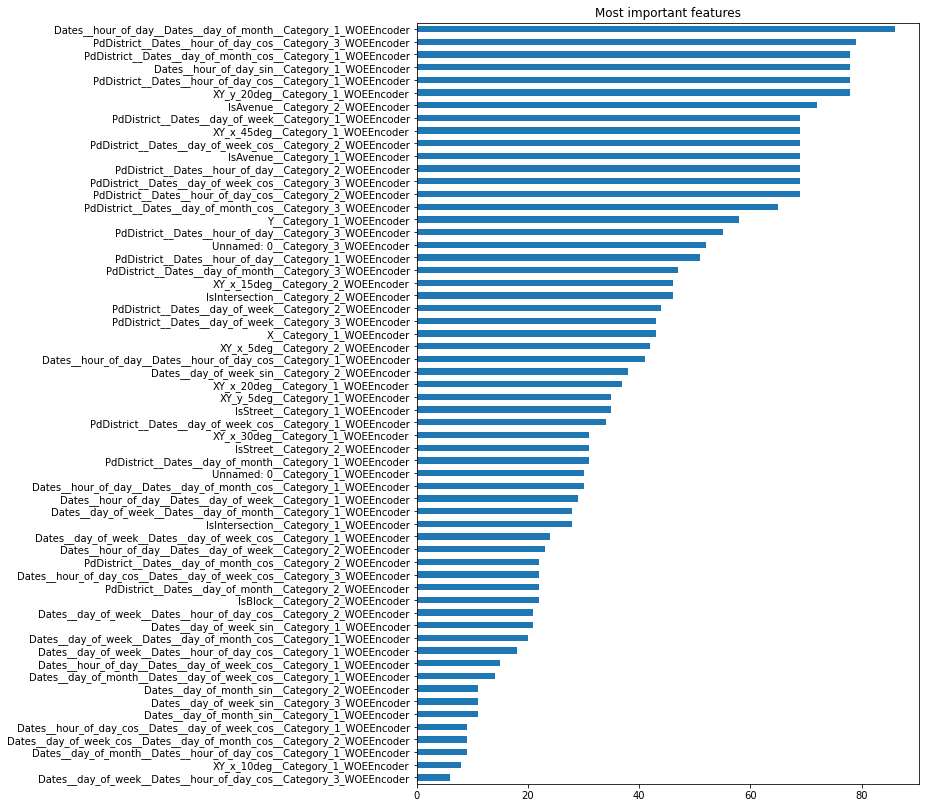

In [20]:
hyper.get_feature_importances().iloc[::-1].plot(
    kind='barh', 
    figsize=(9, 14), 
    title='Most important features',
);

In [429]:
hyper.history.sort_values('loss')

,colsample_bytree,learning_rate,max_depth,subsample,loss,status,id
6,0.588938,0.449428,2.0,0.870533,-0.471062,ok,6
65,0.850499,0.421657,2.0,0.998417,-0.470783,ok,65
80,0.817765,0.272677,2.0,0.966880,-0.470758,ok,80
88,0.711390,0.219398,2.0,0.832755,-0.470647,ok,88
1,0.717344,0.322430,2.0,0.624771,-0.470250,ok,1
...,...,...,...,...,...,...,...
37,0.393774,0.175517,1.0,0.511602,-0.433332,ok,37
49,0.566618,0.156329,1.0,0.623764,-0.432785,ok,49
3,0.353173,0.139018,1.0,0.622953,-0.430232,ok,3
10,0.838495,0.109177,1.0,0.495630,-0.419301,ok,10


In [430]:
import dill
model_np = copy.copy(hyper.model)
model_path = 'models/model_xgb_sfcrime.dill'
with open(model_path, 'wb') as file:
    dill.dump(model_np, file)

### pandas

In [431]:
model_pd = copy.copy(model_np)
_ = model_pd.fit(X_train_prod_prepro, y_train)

### treelite

In [432]:
LGBMTreeliteDumper.dump(
    model=model_np,
    toolchain='gcc',
    parallel_comp=6,
    model_path='models/',
    model_name='treelite_lgbm_sfcrime'
)

[11:53:50] /Users/travis/build/dmlc/treelite/src/compiler/ast/split.cc:29: Parallel compilation enabled; member trees will be divided into 6 translation units.
[11:53:55] /Users/travis/build/dmlc/treelite/src/compiler/ast_native.cc:703: Using ASTNativeCompiler
[11:53:55] /Users/travis/build/dmlc/treelite/src/compiler/ast/split.cc:29: Parallel compilation enabled; member trees will be divided into 6 translation units.
[11:53:55] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:92: Code generation finished. Writing code to files...
[11:53:55] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file recipe.json...
[11:53:55] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file tu4.c...
[11:53:55] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file tu3.c...
[11:53:55] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file tu2.c...
[11:53:55] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file tu1.c...
[11:

In [433]:
import treelite_runtime
model_tl = treelite_runtime.Predictor(
    './models/treelite_lgbm_sfcrime.so', verbose=False)

#### check the models prediction match

In [434]:
X_train_np = X_train.to_numpy()
y_pred_pd = model_pd.predict(
    prod_pipe.transform(X_train_prod))
y_pred_np = model.predict(
    prod_pipe.transform_numpy(X_train_prod_np.copy()))
y_pred_tl = model_tl.predict(
    treelite_runtime.DMatrix(
        prod_pipe.transform_numpy(
            X_train_prod_np.copy()
        )
    )
)
assert np.allclose(y_pred_np, y_pred_pd)
assert np.allclose(y_pred_np, np.argmax(y_pred_tl, axis=1))

AssertionError: 

## model evaluation

In [435]:
model_np = copy.copy(hyper.model)
X_test_prod = X_test.copy()
X_test_prod_prepro_np = prod_pipe.transform(X_test_prod).to_numpy()
y_test_pred = model_np.predict(X_test_prod_prepro_np)
f'f1 score: {f1_score(y_test, y_test_pred, average="micro"):.2f}'

'f1 score: 0.56'

## per-sample bechmarking

### pipeline only

In [409]:
x = X_train_prod.iloc[[0]]
xnp = x.to_numpy()
stats_pd = %timeit -o prod_pipe.transform(x)
stats_np = %timeit -o prod_pipe.transform_numpy(xnp.copy())

198 ms ± 8.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
126 µs ± 2.92 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [410]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_np).split(' ')[0])
f'Speed-up Pandas VS Numpy x{round(speedup)}'

'Speed-up Pandas VS Numpy x1571'

### pipeline & model

In [411]:
stats_pd = %timeit -o model_pd.predict(prod_pipe.transform(x))[0]
stats_np = %timeit -o model.predict(prod_pipe.transform_numpy(xnp.copy()))[0]
stats_tl = %timeit -o model_tl.predict(treelite_runtime.DMatrix(prod_pipe.transform_numpy(xnp.copy())))

243 ms ± 5.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
477 µs ± 5.24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
205 µs ± 8.05 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [412]:
speedup = 1000 * float(str(stats_pd).split(' ')[0]) / float(str(stats_np).split(' ')[0])
f'Speed-up Pandas VS Numpy x{round(speedup)}'

'Speed-up Pandas VS Numpy x509'

In [413]:
speedup = 1000 * float(str(stats_pd).split(' ')[0]) / float(str(stats_tl).split(' ')[0])
f'Speed-up Pandas VS Numpy&Treelite x{round(speedup)}'

'Speed-up Pandas VS Numpy&Treelite x1185'